# Matrix Image Reader (M.I.R)
M.I.R helps you quickly create matrix objects with an image of one. Just scan a quick image and run it through the code, and you can quickly apply operations, like dot and cross product, RREF, finding determinant or eigenvectors, and more!

# Import libraries

In [409]:
import numpy as np
import cv2
from google.colab import files
import matplotlib.pyplot as plt
import tensorflow as tf
from typing import Tuple
import sympy

In [2]:
def upload_files():
  '''Upload files from personal computer to Google Colab'''
  uploaded = files.upload()
  for k, v in uploaded.items():
    open(k, 'wb').write(v)
  return list(uploaded.keys())

In [369]:
upload_files()

Saving test2.png to test2 (6).png


['test2.png']

# Creating the Digit Recognition Model
Credit to Sendex, thank you!

URL: https://www.youtube.com/watch?v=wQ8BIBpya2k

In [7]:
mnist = tf.keras.datasets.mnist # 28x28 images of handwritten digits (0-9)

# Obtain training and testing data
(x_train, y_train), (x_test, y_test) = mnist.load_data()

x_train = tf.keras.utils.normalize(x_train, axis=1)
x_test = tf.keras.utils.normalize(x_test, axis=1)

model = tf.keras.models.Sequential()
model.add(tf.keras.layers.Flatten())
model.add(tf.keras.layers.Dense(128, activation=tf.nn.relu))
model.add(tf.keras.layers.Dense(128, activation=tf.nn.relu))
model.add(tf.keras.layers.Dense(10, activation=tf.nn.softmax))

model.compile(optimizer='adam',
    loss='sparse_categorical_crossentropy',
    metrics=['accuracy'])

model.fit(x_train, y_train, epochs=3)

val_loss, val_acc = model.evaluate(x_test, y_test)
print(val_loss, val_acc)

11493376/11490434 [==============================] - 0s 0us/step
Epoch 1/3
1875/1875 [==============================] - 5s 2ms/step - loss: 0.4725 - accuracy: 0.8612
Epoch 2/3
1875/1875 [==============================] - 4s 2ms/step - loss: 0.1089 - accuracy: 0.9672
Epoch 3/3
313/313 [==============================] - 0s 1ms/step - loss: 0.0903 - accuracy: 0.9719
0.09028234332799911 0.9718999862670898


In [8]:
predictions = model.predict([x_test])
print(np.argmax(predictions[0]))

Consider rewriting this model with the Functional API.
7


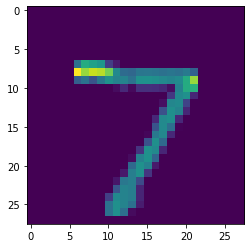

In [9]:
plt.imshow(x_test[0])

In [18]:
tf.keras.models.save_model(model, 'digit.model')

INFO:tensorflow:Assets written to: digit.model/assets


# Predict the Digits

In [196]:
def predict_digit(digit, dim=(28, 28)):
  digit = cv2.resize(digit, dim)
  digit = np.reshape(digit, (1, 28, 28))
  prediction = model.predict(digit)
  return np.argmax(prediction)

# Obtaining the Digits from Matrix

In [410]:
def draw_borders(fname: str='test1.png', dim: Tuple=(3,3)) -> sympy.Matrix:
    '''Draws borders around each digit of the matrix and 
       predicts them.

    Args:
      fname (str): the filepath to image
      dim (str): the dimension of the matrix (mxn)

    Returns:
      sympy.Matrix: the sympy Matrix object
    '''
    
    # Reading in the image
    img = cv2.imread(fname) 
    images = [] # later to append predictted numbers

    # Resize to 512x512 pixel image 
    img = cv2.resize(img, (512, 512), interpolation=cv2.INTER_NEAREST)

    # Turn image to gray scale
    gray = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)

    # Use Gaussian blur to reduce # of noisy edges
    blur = cv2.GaussianBlur(src=gray, ksize=(13, 13), sigmaX=1)

    # Seperate foreground and background, results in clearer matrix
    thresh = cv2.adaptiveThreshold(blur, 255, cv2.ADAPTIVE_THRESH_GAUSSIAN_C,
                                   cv2.THRESH_BINARY, 199, 25)

    # Invert image
    thresh = 255*(thresh < 128).astype(np.uint8)

    # Find contours
    contours, hierarchy = cv2.findContours(
        thresh, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)

    # Remove the two brackets on the side
    contours = sorted(
        contours, key=lambda x: cv2.contourArea(x), reverse=True)[2:]
    
    # Read contours in order left-to-right, top-to-bottom
    contours = sorted(
        contours, key=lambda x: cv2.boundingRect(x)[0]*40 + cv2.boundingRect(x)[1]*200)
    
    # Loop through each contour
    for cnt in contours:
        # We don't want noisy useless edges
        if cv2.contourArea(cnt) > 50:
          # Find rectangle coords
          x, y, w, h = cv2.boundingRect(cnt)

          # Draw border
          cv2.rectangle(thresh, (x-7, y-7), (x+w+7, y+h+7), (255, 255, 255))

          # Get sectioned off digits
          digit = thresh[y-2:y+h+2, x-2:x+w+2]

          # Add padding around image
          padded_digit = np.pad(digit, ((7,7),(7,7)), "constant", constant_values=0)

          # Predict the digits and append to image
          images.append(predict_digit(padded_digit))
    
    # Show the border
    plt.imshow(thresh)
    return sympy.Matrix(np.array(images).reshape(dim))

Matrix([
[9, 4, 4],
[1, 6, 7],
[7, 8, 8]])

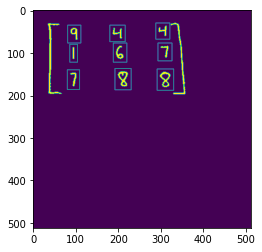

In [419]:
m1 = draw_borders()
m1

Matrix([
[1, 8, 9, 4],
[6, 7, 7, 2],
[6, 2, 3, 4],
[1, 5, 8, 8]])

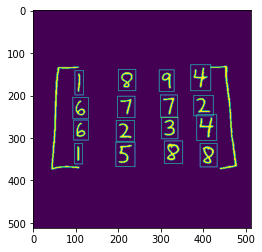

In [418]:
m2 = draw_borders('test2.png', dim=(4, 4))
m2

Matrix([
[9],
[7],
[6]])

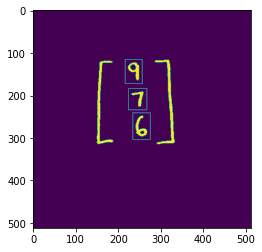

In [417]:
m3 = draw_borders('test3.png', dim=(3, 1))
m3

Matrix([
[1, 2, 3],
[4, 5, 6],
[7, 8, 9]])

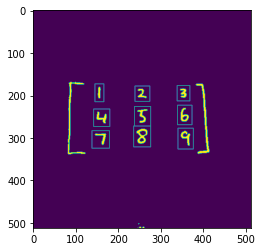

In [416]:
m4 = draw_borders('test4.png', dim=(3, 3))
m4

# Sympy Matrix Operation

URL: https://docs.sympy.org/latest/tutorial/matrices.html

In [428]:
display(m1, m4) # Multiply matrices
m1 * m4

Matrix([
[9, 4, 4],
[1, 6, 7],
[7, 8, 8]])

Matrix([
[1, 2, 3],
[4, 5, 6],
[7, 8, 9]])

Matrix([
[53,  70,  87],
[74,  88, 102],
[95, 118, 141]])

In [429]:
m1.inv()

Matrix([
[  2/11,  0,  -1/11],
[-41/44, -1,  59/44],
[ 17/22,  1, -25/22]])

In [423]:
m2.rref()

(Matrix([
 [1, 0, 0, 0],
 [0, 1, 0, 0],
 [0, 0, 1, 0],
 [0, 0, 0, 1]]), (0, 1, 2, 3))

In [424]:
m2.columnspace()

[Matrix([
 [1],
 [6],
 [6],
 [1]]), Matrix([
 [8],
 [7],
 [2],
 [5]]), Matrix([
 [9],
 [7],
 [3],
 [8]]), Matrix([
 [4],
 [2],
 [4],
 [8]])]

In [425]:
m2.nullspace()

[]

In [426]:
m2.det()

70